# Spotify Song Popularity Prediction: KNN Model Comparison

**Project Overview:** This project compares multiple K-Nearest Neighbors (KNN) regression models to predict song popularity rankings using quantitative features from streaming platforms.

**Objective:** Predict **All Time Rank** (continuous target variable) from quantitative features including streams, popularity metrics, playlist counts, Track Score, and other audio metrics.

**Model Variants:**
- **Variant 1:** KNN with k=5, uniform weights
- **Variant 2:** KNN with k=10, uniform weights
- **Variant 3:** KNN with k=5, distance-based weights
- **Variant 4:** KNN with k=15, uniform weights


In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

CSV_PATH = r"C:\Users\chenz\OneDrive\Desktop\Projects\cogs109\Most Streamed Spotify Songs 2024.csv"
RANDOM_STATE = 42
FIG_DIR = r"C:\Users\chenz\OneDrive\Desktop\Projects\cogs109\figures"
os.makedirs(FIG_DIR, exist_ok=True)

In [2]:
# Robust CSV load
encodings = ["utf-8","utf-8-sig","cp1252","latin1","ISO-8859-1"]
for enc in encodings:
    try:
        df = pd.read_csv(CSV_PATH, encoding=enc, on_bad_lines='skip', engine='python')
        print("Loaded with encoding:", enc); break
    except Exception as e:
        last_err = e
else:
    raise last_err
print("Shape:", df.shape)
print("Columns sample:", list(df.columns)[:25], "...")
display(df.head(5))

Loaded with encoding: cp1252
Shape: (4600, 29)
Columns sample: ['Track', 'Album Name', 'Artist', 'Release Date', 'ISRC', 'All Time Rank', 'Track Score', 'Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts', 'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach', 'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins', 'Deezer Playlist Count', 'Deezer Playlist Reach', 'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations'] ...


,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0
1,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,USUG12400910,2,545.9,"323,703,884","28,113","174,597,137",...,3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",NaN,1
2,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,QZJ842400387,3,538.4,"601,309,283","54,331","211,607,669",...,536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",NaN,0
3,Flowers,Flowers - Single,Miley Cyrus,1/12/2023,USSM12209777,4,444.9,"2,031,280,633","269,802","136,569,078",...,"2,182",264.0,"24,684,248",210.0,"190,260,277","203,384",NaN,"11,822,942",NaN,0
4,Houdini,Houdini,Eminem,5/31/2024,USUG12403398,5,423.3,"107,034,922","7,223","151,469,874",...,1,82.0,"17,660,624",105.0,"4,493,884","7,006","207,179","457,017",NaN,1


In [3]:
# Choose continuous target: prefer 'All Time Rank' family, else general 'Rank' names
preferred = [
    'All Time Rank','All-Time Rank','AllTime Rank','All Time Ranking','All Time Overall Rank',
    'Overall Rank','overall_rank','track_rank','Track Rank','Rank','rank','spotify_rank'
]
target_col = None
ci = {c.casefold(): c for c in df.columns}
for key in [k.casefold() for k in preferred]:
    if key in ci:
        target_col = ci[key]; break

# Fallback: last numeric column if no rank-like column found
if target_col is None:
    num_cols = df.select_dtypes(include='number').columns.tolist()
    assert len(num_cols)>0, "No numeric columns for regression target."
    target_col = num_cols[-1]
    print("WARNING: Falling back to numeric column as target:", target_col)
else:
    print("Target column:", target_col)

Target column: All Time Rank


In [ ]:

# --- Numeric cleanup: coerce strings like '1,892' or '12.3%' to numbers ---
import re

def coerce_numeric_columns(df, extra_cols=None):
    """
    Convert object columns that look numeric (commas, % , $ etc.) to floats.
    Optionally include specific extra columns (e.g., the chosen target).
    """
    work = df.copy()
    cand = work.select_dtypes(include='object').columns.tolist()
    if extra_cols:
        for c in extra_cols:
            if c not in cand and c in work.columns:
                cand.append(c)
    for c in cand:
        s = work[c].astype(str)
        # quick heuristic: contains digits
        if s.str.contains(r"\d").any():
            s2 = (
                s.str.replace(",", "", regex=False)
                 .str.replace("%", "", regex=False)
                 .str.replace("$", "", regex=False)
                 .str.replace(u"\u202f", "", regex=False)  # narrow no-break space
                 .str.replace(" ", "", regex=False)
            )
            num = pd.to_numeric(s2, errors="coerce")
            # only convert if a meaningful amount of numbers is obtained
            if num.notna().mean() > 0.5:
                work[c] = num
    return work

# Apply to the whole dataframe, ensuring the target (target_col) is also coerced
df = coerce_numeric_columns(df, extra_cols=[target_col] if 'target_col' in locals() else None)

# Confirm target is numeric
if not pd.api.types.is_numeric_dtype(df[target_col]):
    raise ValueError(f"Target column '{target_col}' is not numeric after coercion. Please inspect its values.")


## EDA

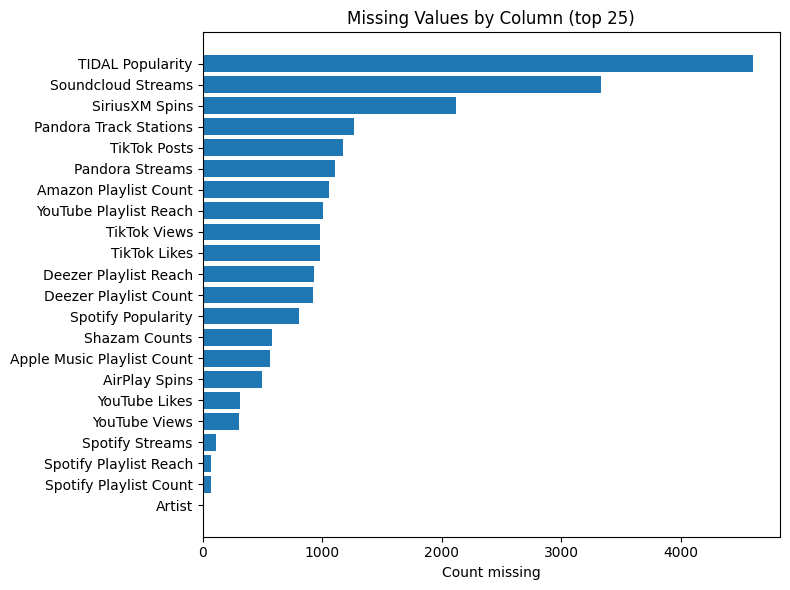

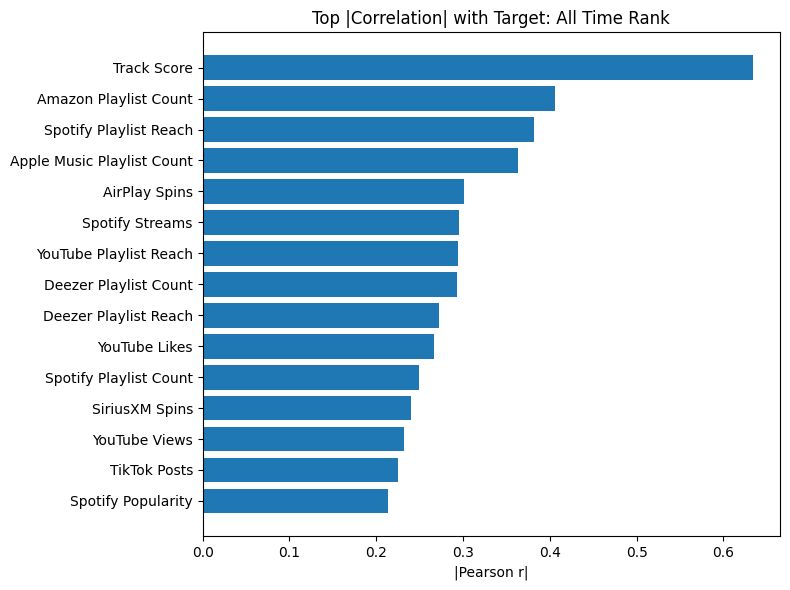

In [5]:
# Missingness (top 25) and top |correlation| with target
ms = df.isna().sum()
ms = ms[ms>0].sort_values(ascending=True).tail(25)
if len(ms)>0:
    fig = plt.figure(figsize=(8,6))
    plt.barh(ms.index, ms.values); plt.title("Missing Values by Column (top 25)")
    plt.xlabel("Count missing"); plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR,"missingness.png"), dpi=200, bbox_inches='tight')
    plt.show()

num_df = df.select_dtypes(include='number')
if target_col in num_df.columns:
    corrs = num_df.corr(numeric_only=True)[target_col].drop(labels=[target_col]).dropna().abs().sort_values(ascending=False).head(15)
    if len(corrs)>0:
        fig = plt.figure(figsize=(8,6))
        plt.barh(corrs.index[::-1], corrs.values[::-1])
        plt.title(f"Top |Correlation| with Target: {target_col}")
        plt.xlabel("|Pearson r|"); plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR,"top_corrs.png"), dpi=200, bbox_inches='tight')
        plt.show()

In [6]:
# Features: numeric columns excluding the target (meta-only; this CSV lacks raw audio descriptors)
numeric_cols = df.select_dtypes(include='number').columns.tolist()
if target_col in numeric_cols: numeric_cols.remove(target_col)

# Drop rank-like leakage features if multiple ranks exist
rank_like = {'All Time Rank','All-Time Rank','AllTime Rank','All Time Ranking','Overall Rank','overall_rank','track_rank','Track Rank','Rank','rank','spotify_rank'}
features = [c for c in numeric_cols if c not in rank_like]

print("Using features (first 20):", features[:20], ("...(+ more)" if len(features)>20 else ""))

X = df[features].copy()
y = df[target_col].copy()

mask = ~y.isna()
X, y = X[mask], y[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train.shape, X_test.shape

Using features (first 20): ['Track Score', 'Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts', 'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach', 'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins', 'Deezer Playlist Count', 'Deezer Playlist Reach', 'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations', 'Shazam Counts'] ...(+ more)


((3680, 22), (920, 22))

In [ ]:
# Pipeline & Model Variants: KNN Regression Models
pre = ColumnTransformer([('num', Pipeline([('imputer', SimpleImputer(strategy='median')),
                                          ('scaler', StandardScaler())]),
                           X.columns.tolist())])

# Define four KNN model variants for comparison
# Testing different k values and weighting schemes to find optimal configuration
variants = {
    'Variant 1: KNN (k=5, uniform)': KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto'),
    'Variant 2: KNN (k=10, uniform)': KNeighborsRegressor(n_neighbors=10, weights='uniform', algorithm='auto'),
    'Variant 3: KNN (k=5, distance)': KNeighborsRegressor(n_neighbors=5, weights='distance', algorithm='auto'),
    'Variant 4: KNN (k=15, uniform)': KNeighborsRegressor(n_neighbors=15, weights='uniform', algorithm='auto')
}

# Train and evaluate all variants
results = {}
predictions = {}
cv_results = {}

# Setup k-fold cross-validation (k=5)
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("="*80)
print("MODEL FITTING AND EVALUATION")
print("="*80)
print("NOTE: For distance-weighted KNN (Variant 3), using leave-one-out CV for training")
print("      predictions to avoid the issue where each point is its own nearest neighbor")
print("      (distance=0 → infinite weight → artificially perfect training fit).")
print("="*80)

for variant_name, model in variants.items():
    pipe = Pipeline([('pre', pre), ('model', model)]).fit(X_train, y_train)
    
    # For distance-weighted KNN, training predictions are problematic because
    # each point can be its own nearest neighbor (distance=0), causing infinite weight.
    # Use leave-one-out CV for training error to properly exclude each point from itself.
    if 'distance' in variant_name.lower():
        # Use leave-one-out cross-validation for training predictions
        loo = LeaveOneOut()
        pred_tr_list = []
        for train_idx, val_idx in loo.split(X_train):
            # Fit on all but one point
            pipe_loo = Pipeline([('pre', pre), ('model', model)]).fit(
                X_train.iloc[train_idx], y_train.iloc[train_idx]
            )
            # Predict on the left-out point
            pred_tr_list.append(pipe_loo.predict(X_train.iloc[val_idx])[0])
        pred_tr = np.array(pred_tr_list)
    else:
        # For uniform weights, standard prediction is fine
        pred_tr = pipe.predict(X_train)
    
    # Test predictions (always standard)
    pred_te = pipe.predict(X_test)
    
    # Training and test metrics
    rmse_tr = mean_squared_error(y_train, pred_tr) ** 0.5
    rmse_te = mean_squared_error(y_test, pred_te) ** 0.5
    r2_tr = r2_score(y_train, pred_tr)
    r2_te = r2_score(y_test, pred_te)
    
    # Cross-validation (on training set)
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=kfold, 
                                scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    cv_rmse_mean = cv_rmse.mean()
    cv_rmse_std = cv_rmse.std()
    
    # Store results
    results[variant_name] = {
        'rmse_train': rmse_tr,
        'rmse_test': rmse_te,
        'r2_train': r2_tr,
        'r2_test': r2_te,
        'cv_rmse_mean': cv_rmse_mean,
        'cv_rmse_std': cv_rmse_std,
        'pipe': pipe
    }
    predictions[variant_name] = {
        'train': pred_tr,
        'test': pred_te
    }
    cv_results[variant_name] = cv_rmse
    
    print(f"\n{variant_name}:")
    print(f"  Train RMSE={rmse_tr:.4f}, R²={r2_tr:.4f}")
    print(f"  Test  RMSE={rmse_te:.4f}, R²={r2_te:.4f}")
    print(f"  CV RMSE={cv_rmse_mean:.4f} (±{cv_rmse_std:.4f})")

# Calculate Adjusted R², AIC, BIC for model comparison
print("\n" + "="*80)
print("MODEL COMPARISON METRICS")
print("="*80)

# AIC/BIC computation for model comparison
# Using a simplified approximation suitable for KNN regression
model_comparison = {}

for variant_name, preds in predictions.items():
    n = len(y_test)
    residuals = y_test - preds['test']
    mse = np.mean(residuals**2)
    n_params = len(X.columns) + 1  # number of features + intercept
    
    # Adjusted R²
    adj_r2 = 1 - (1 - results[variant_name]['r2_test']) * (n - 1) / (n - n_params - 1)
    
    # AIC and BIC (approximate for regression)
    # AIC = n * log(MSE) + 2 * k, where k = number of parameters
    # BIC = n * log(MSE) + k * log(n)
    aic = n * np.log(mse) + 2 * n_params
    bic = n * np.log(mse) + n_params * np.log(n)
    
    model_comparison[variant_name] = {
        'Adjusted R²': adj_r2,
        'AIC': aic,
        'BIC': bic,
        'CV RMSE': results[variant_name]['cv_rmse_mean']
    }
    
    print(f"\n{variant_name}:")
    print(f"  Adjusted R² = {adj_r2:.4f}")
    print(f"  AIC = {aic:.2f}")
    print(f"  BIC = {bic:.2f}")
    print(f"  CV RMSE = {results[variant_name]['cv_rmse_mean']:.4f}")

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Variant': list(results.keys()),
    'Train RMSE': [results[v]['rmse_train'] for v in results.keys()],
    'Test RMSE': [results[v]['rmse_test'] for v in results.keys()],
    'CV RMSE': [results[v]['cv_rmse_mean'] for v in results.keys()],
    'Train R²': [results[v]['r2_train'] for v in results.keys()],
    'Test R²': [results[v]['r2_test'] for v in results.keys()],
    'Adjusted R²': [model_comparison[v]['Adjusted R²'] for v in results.keys()],
    'AIC': [model_comparison[v]['AIC'] for v in results.keys()],
    'BIC': [model_comparison[v]['BIC'] for v in results.keys()]
})

print("\n" + "="*80)
print("COMPREHENSIVE METRICS COMPARISON TABLE")
print("="*80)
display(comparison_df)

MODEL FITTING AND EVALUATION
NOTE: For distance-weighted KNN (Variant 3), using leave-one-out CV for training
      predictions to avoid the issue where each point is its own nearest neighbor
      (distance=0 → infinite weight → artificially perfect training fit).


C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-


Variant 1: KNN (k=5, uniform):
  Train RMSE=626.0436, R²=0.7732
  Test  RMSE=804.7949, R²=0.6460
  CV RMSE=785.9428 (±17.8834)


C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-


Variant 2: KNN (k=10, uniform):
  Train RMSE=696.5945, R²=0.7193
  Test  RMSE=806.4541, R²=0.6445
  CV RMSE=791.8111 (±24.1477)


C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-


Variant 3: KNN (k=5, distance):
  Train RMSE=763.8307, R²=0.6624
  Test  RMSE=796.0560, R²=0.6536
  CV RMSE=774.7077 (±19.1057)


C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-


Variant 4: KNN (k=15, uniform):
  Train RMSE=736.5742, R²=0.6861
  Test  RMSE=819.7890, R²=0.6326
  CV RMSE=808.9827 (±19.1061)

MODEL COMPARISON METRICS

Variant 1: KNN (k=5, uniform):
  Adjusted R² = 0.6369
  AIC = 12356.68
  BIC = 12467.64
  CV RMSE = 785.9428

Variant 2: KNN (k=10, uniform):
  Adjusted R² = 0.6354
  AIC = 12360.47
  BIC = 12471.43
  CV RMSE = 791.8111

Variant 3: KNN (k=5, distance):
  Adjusted R² = 0.6447
  AIC = 12336.59
  BIC = 12447.55
  CV RMSE = 774.7077

Variant 4: KNN (k=15, uniform):
  Adjusted R² = 0.6232
  AIC = 12390.65
  BIC = 12501.61
  CV RMSE = 808.9827

COMPREHENSIVE METRICS COMPARISON TABLE


C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\chenz\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['TIDAL Popularity']. At least one non-

,Variant,Train RMSE,Test RMSE,CV RMSE,Train R²,Test R²,Adjusted R²,AIC,BIC
0,"Variant 1: KNN (k=5, uniform)",626.043625,804.794926,785.942837,0.773245,0.645954,0.636865,12356.680989,12467.641583
1,"Variant 2: KNN (k=10, uniform)",696.594473,806.454079,791.811092,0.719258,0.644492,0.635367,12360.470402,12471.430997
2,"Variant 3: KNN (k=5, distance)",763.830729,796.056035,774.707709,0.662448,0.653601,0.644709,12336.592025,12447.552619
3,"Variant 4: KNN (k=15, uniform)",736.574162,819.789044,808.982715,0.686108,0.632638,0.623208,12390.646560,12501.607154


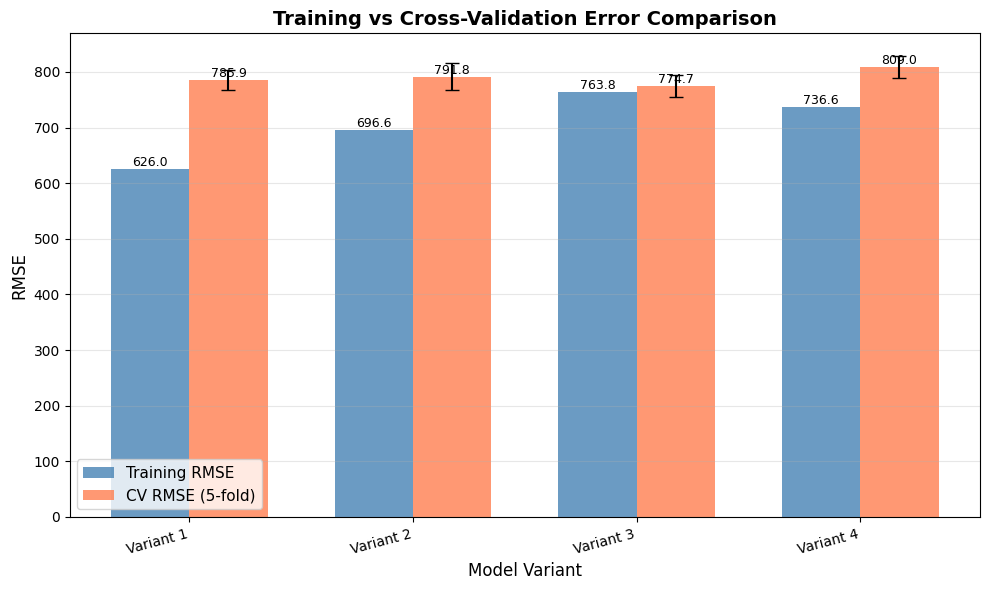

Saved: C:\Users\chenz\OneDrive\Desktop\Projects\cogs109\figures\train_cv_error_comparison.png


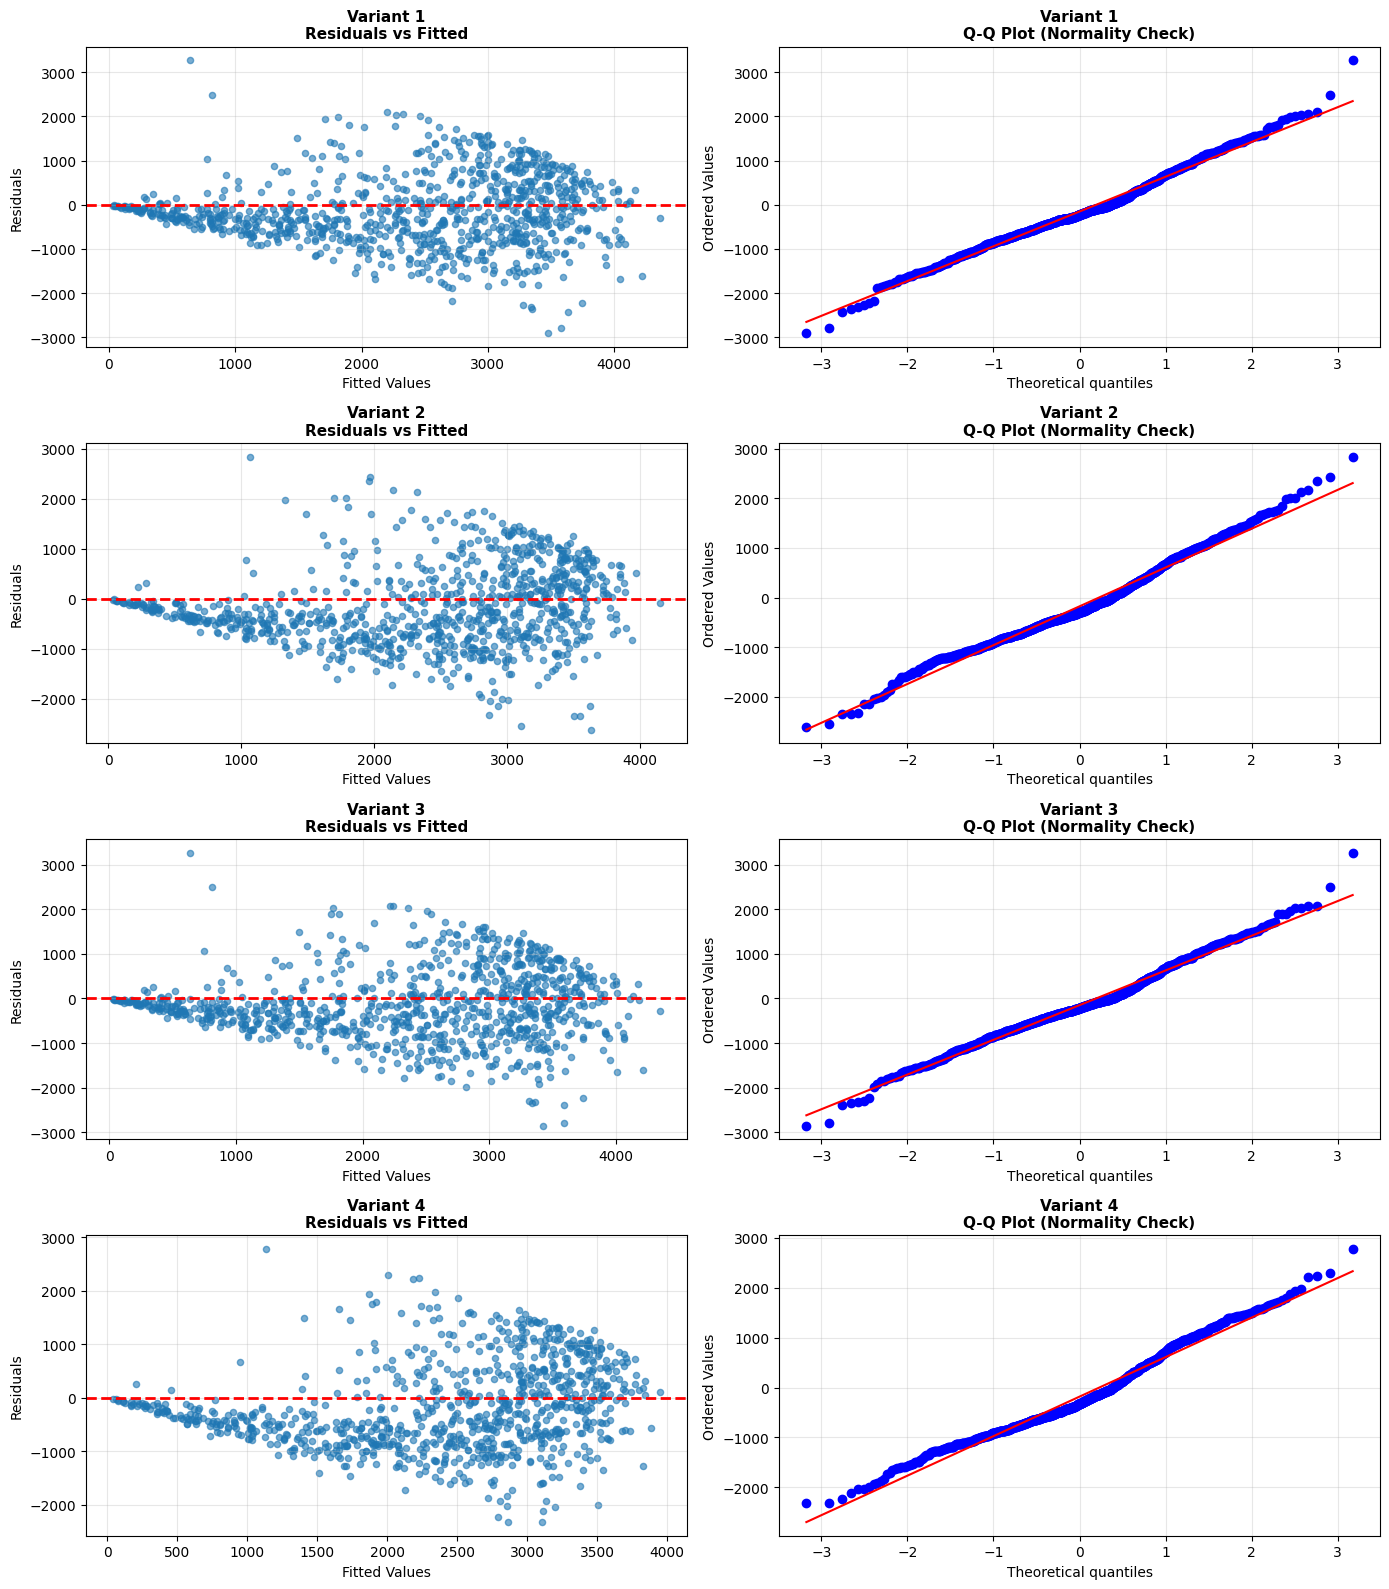

Saved: C:\Users\chenz\OneDrive\Desktop\Projects\cogs109\figures\residual_assumptions.png


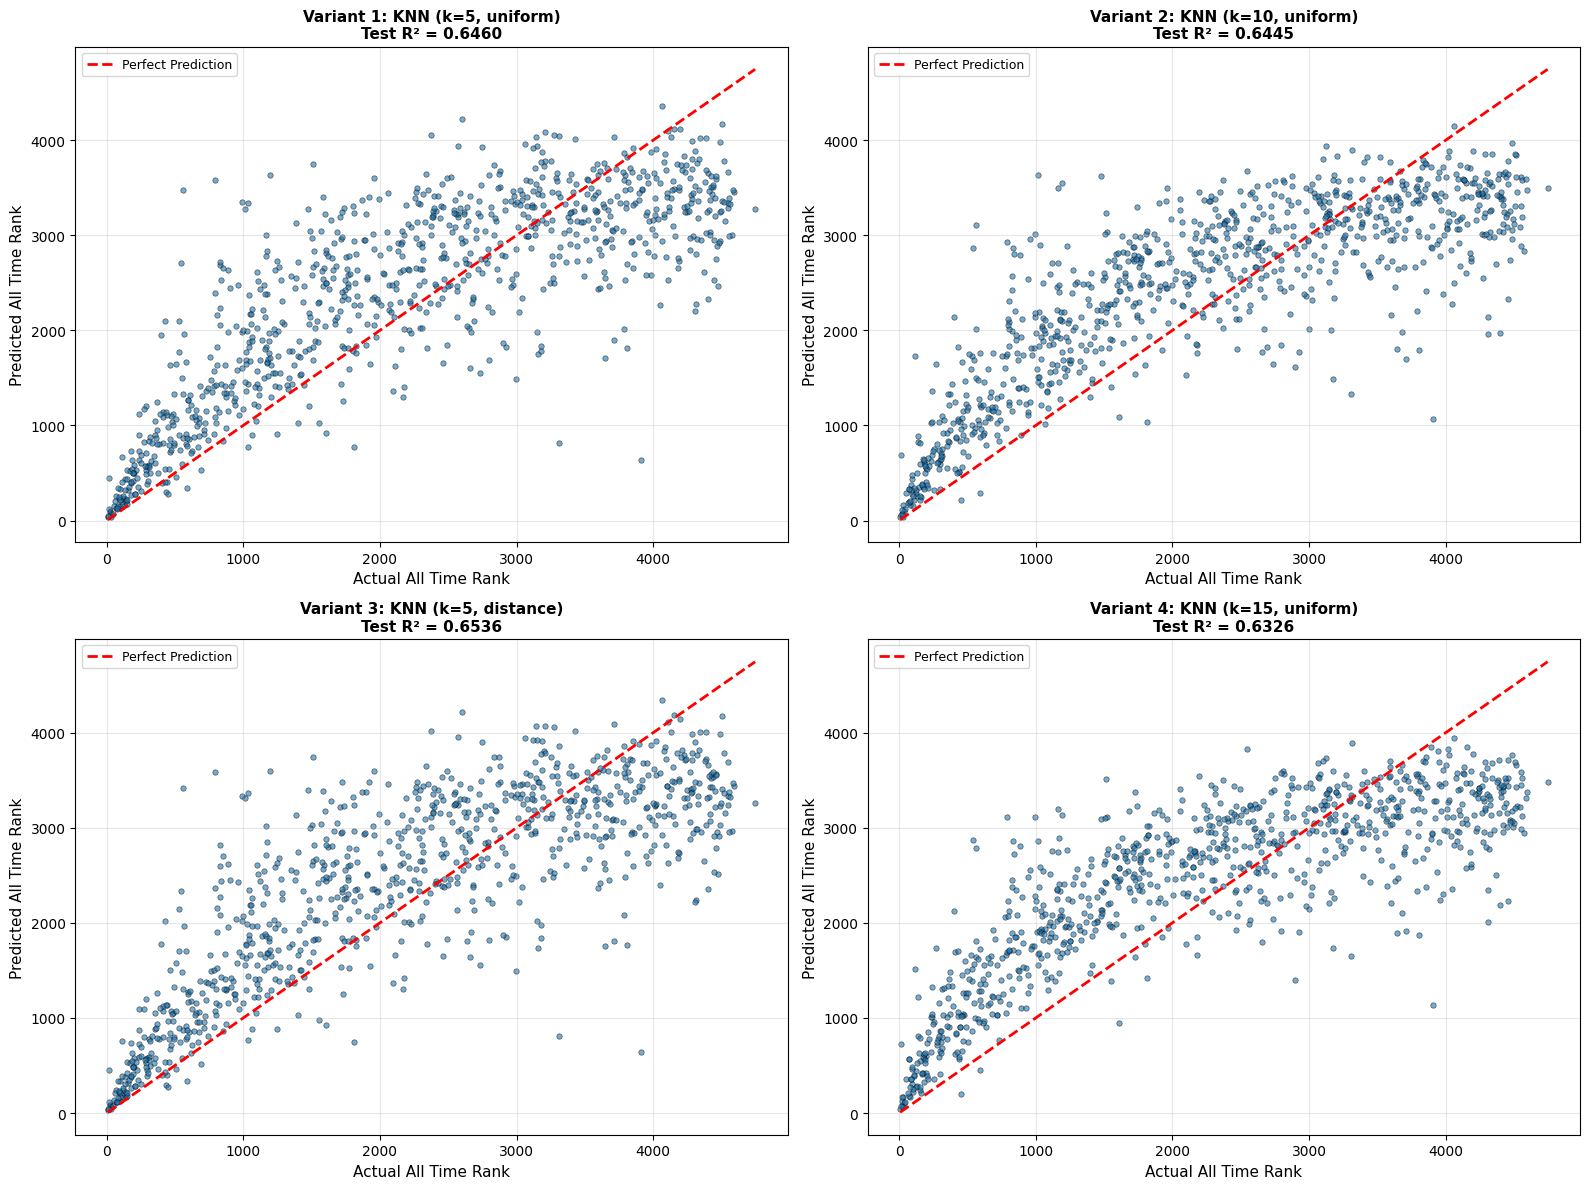

Saved: C:\Users\chenz\OneDrive\Desktop\Projects\cogs109\figures\pred_vs_actual_checkpoint3.png


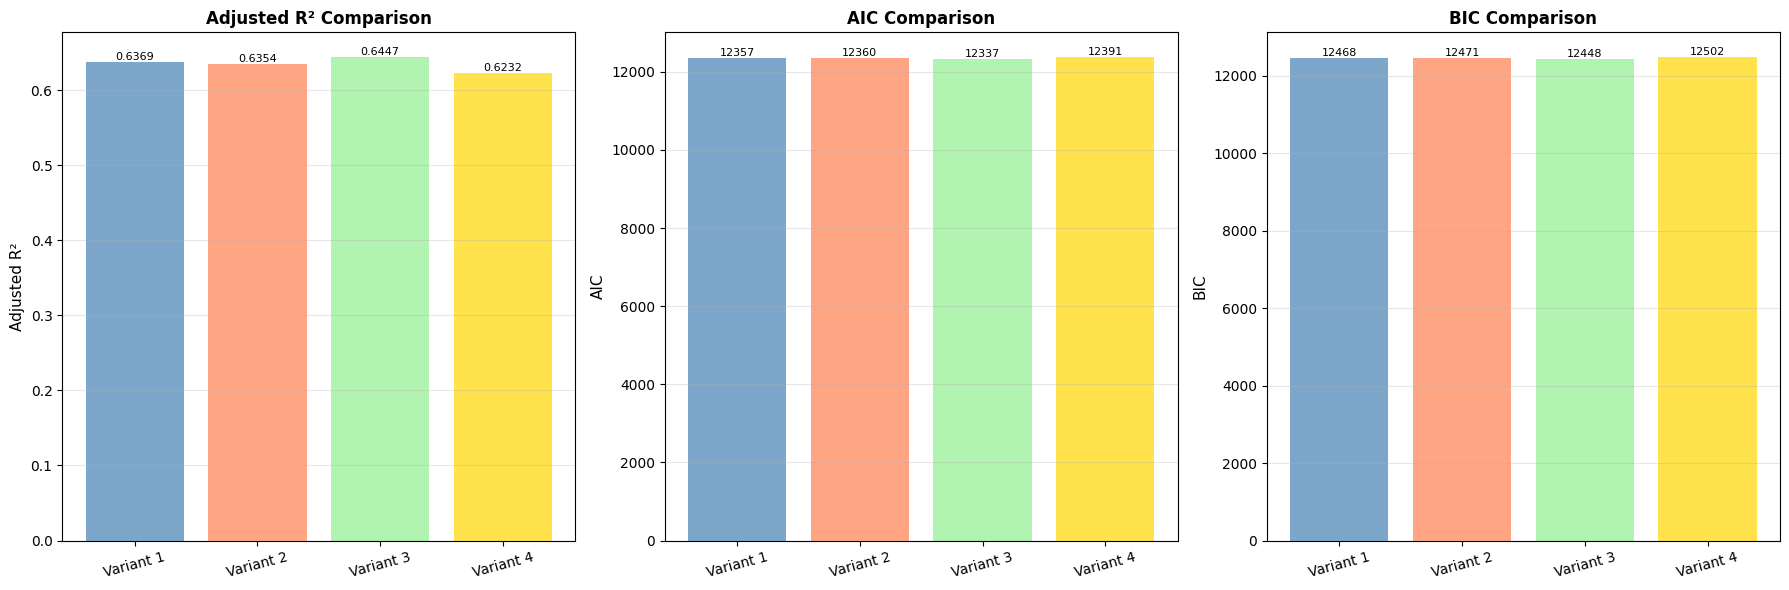

Saved: C:\Users\chenz\OneDrive\Desktop\Projects\cogs109\figures\model_metrics_comparison.png

All figures saved successfully!


In [ ]:
# FIGURE 1: Training and Cross-Validation Error Comparison
fig, ax = plt.subplots(figsize=(10, 6))
variants_list = list(results.keys())
train_rmse = [results[v]['rmse_train'] for v in variants_list]
cv_rmse = [results[v]['cv_rmse_mean'] for v in variants_list]
cv_std = [results[v]['cv_rmse_std'] for v in variants_list]

x = np.arange(len(variants_list))
width = 0.35

bars1 = ax.bar(x - width/2, train_rmse, width, label='Training RMSE', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, cv_rmse, width, label='CV RMSE (5-fold)', alpha=0.8, color='coral', 
               yerr=cv_std, capsize=5)

ax.set_xlabel('Model Variant', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Training vs Cross-Validation Error Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([v.split(':')[0] for v in variants_list], rotation=15, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
cv_comparison_path = os.path.join(FIG_DIR, "train_cv_error_comparison.png")
plt.savefig(cv_comparison_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {cv_comparison_path}")

# FIGURE 2: Residual Plots for Assumption Checking
# 4 models: 4 rows x 2 columns (residuals vs fitted, Q-Q plot)
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()

for idx, (variant_name, preds) in enumerate(predictions.items()):
    residuals = y_test - preds['test']
    fitted = preds['test']
    
    # Residuals vs Fitted
    ax = axes[idx*2]
    ax.scatter(fitted, residuals, alpha=0.6, s=20)
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax.set_xlabel('Fitted Values', fontsize=10)
    ax.set_ylabel('Residuals', fontsize=10)
    ax.set_title(f'{variant_name.split(":")[0]}\nResiduals vs Fitted', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Q-Q Plot for normality
    ax = axes[idx*2 + 1]
    stats.probplot(residuals, dist="norm", plot=ax)
    ax.set_title(f'{variant_name.split(":")[0]}\nQ-Q Plot (Normality Check)', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
residual_plots_path = os.path.join(FIG_DIR, "residual_assumptions.png")
plt.savefig(residual_plots_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {residual_plots_path}")

# FIGURE 3: Predicted vs Actual (for all 4 variants)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (variant_name, preds) in enumerate(predictions.items()):
    ax = axes[idx]
    pred_te = preds['test']
    ax.scatter(y_test, pred_te, s=15, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line
    mn = min(y_test.min(), pred_te.min())
    mx = max(y_test.max(), pred_te.max())
    ax.plot([mn, mx], [mn, mx], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual All Time Rank', fontsize=11)
    ax.set_ylabel('Predicted All Time Rank', fontsize=11)
    ax.set_title(f'{variant_name}\nTest R² = {results[variant_name]["r2_test"]:.4f}', 
                 fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
pred_actual_path = os.path.join(FIG_DIR, "pred_vs_actual.png")
plt.savefig(pred_actual_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {pred_actual_path}")

# FIGURE 4: Model Comparison Metrics (AIC, BIC, Adjusted R²) - Bar Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
metrics = ['Adjusted R²', 'AIC', 'BIC']
variant_labels = [v.split(':')[0] for v in variants_list]
colors = ['steelblue', 'coral', 'lightgreen', 'gold'][:len(variants_list)]

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    values = [model_comparison[v][metric] for v in variants_list]
    
    bars = ax.bar(variant_labels, values, alpha=0.7, color=colors)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=15)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        if metric == 'Adjusted R²':
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=8)
        else:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
metrics_comparison_path = os.path.join(FIG_DIR, "model_metrics_comparison.png")
plt.savefig(metrics_comparison_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {metrics_comparison_path}")

print("\n" + "="*80)
print("All figures saved successfully!")
print("="*80)


## Model Descriptions

All variants use **K-Nearest Neighbors (KNN) Regressor** with different parameter configurations.

### Variant 1: KNN (k=5, uniform weights)
**Baseline Configuration**

- **Algorithm:** Non-parametric instance-based learning
- **Parameters:** k=5 neighbors, uniform weights
- **Equation:** $\hat{y} = \frac{1}{k}\sum_{i=1}^{k} y_i$ (average of k nearest neighbors)
- **Characteristics:** 
  - Makes predictions based on similarity to training examples
  - All k neighbors contribute equally to prediction
  - Smaller k may capture local patterns but risk overfitting

### Variant 2: KNN (k=10, uniform weights)
**Increased number of neighbors**

- **Algorithm:** Same as Variant 1
- **Parameters:** k=10 neighbors, uniform weights
- **Equation:** Same as Variant 1
- **Characteristics:**
  - Larger k smooths predictions (reduces variance, increases bias)
  - More robust to outliers
  - May miss local patterns

### Variant 3: KNN (k=5, distance-based weights)
**Distance-weighted prediction**

- **Algorithm:** Same as Variant 1
- **Parameters:** k=5 neighbors, distance-based weights
- **Equation:** $\hat{y} = \frac{\sum_{i=1}^{k} w_i y_i}{\sum_{i=1}^{k} w_i}$ where $w_i = \frac{1}{d_i}$ (inverse distance)
- **Characteristics:**
  - Closer neighbors have more influence
  - Can capture local patterns better than uniform weights
  - More sensitive to feature scaling

### Variant 4: KNN (k=15, uniform weights)
**Larger number of neighbors**

- **Algorithm:** Same as Variant 1
- **Parameters:** k=15 neighbors, uniform weights
- **Equation:** Same as Variant 1
- **Characteristics:**
  - Largest k among variants (most smoothing)
  - Highest bias, lowest variance
  - Most robust but may oversmooth


In [ ]:
# Model Selection Summary and Interpretation
print("="*80)
print("MODEL SELECTION SUMMARY")
print("="*80)

# Find best model based on CV RMSE
best_cv_model = min(results.keys(), key=lambda v: results[v]['cv_rmse_mean'])
print(f"\nBest Model by CV RMSE: {best_cv_model}")
print(f"  CV RMSE: {results[best_cv_model]['cv_rmse_mean']:.4f} (±{results[best_cv_model]['cv_rmse_std']:.4f})")
print(f"  Test RMSE: {results[best_cv_model]['rmse_test']:.4f}")
print(f"  Test R²: {results[best_cv_model]['r2_test']:.4f}")

# Find best model by AIC (lower is better)
best_aic_model = min(variants_list, key=lambda v: model_comparison[v]['AIC'])
print(f"\nBest Model by AIC: {best_aic_model}")
print(f"  AIC: {model_comparison[best_aic_model]['AIC']:.2f}")

# Find best model by BIC (lower is better)
best_bic_model = min(variants_list, key=lambda v: model_comparison[v]['BIC'])
print(f"\nBest Model by BIC: {best_bic_model}")
print(f"  BIC: {model_comparison[best_bic_model]['BIC']:.2f}")

# Find best model by Adjusted R² (higher is better)
best_adjr2_model = max(variants_list, key=lambda v: model_comparison[v]['Adjusted R²'])
print(f"\nBest Model by Adjusted R²: {best_adjr2_model}")
print(f"  Adjusted R²: {model_comparison[best_adjr2_model]['Adjusted R²']:.4f}")

print("\n" + "="*80)
print("WHY THESE METRICS?")
print("="*80)
print("""
1. **Cross-Validation RMSE**: Provides unbiased estimate of model performance
   on unseen data. Lower CV error indicates better generalization.

2. **Adjusted R²**: Accounts for model complexity (number of parameters).
   Better than R² for comparing models with different numbers of features.
   Higher values indicate better fit adjusted for complexity.

3. **AIC (Akaike Information Criterion)**: Balances model fit and complexity.
   Penalizes overfitting. Lower AIC indicates better model.
   Formula: AIC = n*log(MSE) + 2*k, where k = number of parameters.

4. **BIC (Bayesian Information Criterion)**: Similar to AIC but with stronger
   penalty for complexity. Lower BIC indicates better model.
   Formula: BIC = n*log(MSE) + k*log(n).

These metrics are suitable for comparing regression models because they:
- Account for model complexity
- Penalize overfitting
- Provide a trade-off between fit quality and parsimony
""")

print("="*80)
print("MAIN CONCLUSIONS")
print("="*80)

# Compare all four KNN variants
print("\nCV RMSE Comparison (lower is better):")
for v in variants_list:
    print(f"  {v.split(':')[0]}: {results[v]['cv_rmse_mean']:.4f}")

print(f"\nModel Characteristics:")
print(f"  - Variant 1 (k=5, uniform): Baseline configuration, moderate k, equal weights")
print(f"  - Variant 2 (k=10, uniform): Larger k, more smoothing, lower variance")
print(f"  - Variant 3 (k=5, distance): Same k as Variant 1, but distance-weighted (closer neighbors matter more)")
print(f"  - Variant 4 (k=15, uniform): Largest k, most smoothing, highest bias/lowest variance")

print(f"\nKey Insights:")
print(f"  - Comparing k values (1 vs 2 vs 4): Effect of number of neighbors on bias-variance tradeoff")
print(f"  - Comparing weighting schemes (1 vs 3): Uniform vs distance-based weights")
print(f"  - Larger k: More smoothing, less sensitive to local patterns, lower variance")
print(f"  - Distance weights: Closer neighbors have more influence, can capture local structure better")


MODEL SELECTION SUMMARY

Best Model by CV RMSE: Variant 3: KNN (k=5, distance)
  CV RMSE: 774.7077 (±19.1057)
  Test RMSE: 796.0560
  Test R²: 0.6536

Best Model by AIC: Variant 3: KNN (k=5, distance)
  AIC: 12336.59

Best Model by BIC: Variant 3: KNN (k=5, distance)
  BIC: 12447.55

Best Model by Adjusted R²: Variant 3: KNN (k=5, distance)
  Adjusted R²: 0.6447

WHY THESE METRICS?

1. **Cross-Validation RMSE**: Provides unbiased estimate of model performance
   on unseen data. Lower CV error indicates better generalization.

2. **Adjusted R²**: Accounts for model complexity (number of parameters).
   Better than R² for comparing models with different numbers of features.
   Higher values indicate better fit adjusted for complexity.

3. **AIC (Akaike Information Criterion)**: Balances model fit and complexity.
   Penalizes overfitting. Lower AIC indicates better model.
   Formula: AIC = n*log(MSE) + 2*k, where k = number of parameters.

4. **BIC (Bayesian Information Criterion)**: Simi

In [ ]:
# KNN Model Interpretation
# Note: KNN is non-parametric, so it doesn't have interpretable coefficients like linear models
# Feature importance can be analyzed through other means or by discussing the effect of parameters

print("="*80)
print("KNN MODEL INTERPRETATION")
print("="*80)
print("""
K-Nearest Neighbors is a non-parametric model, meaning:
- No explicit coefficients to interpret
- Predictions based on similarity to training examples
- Model complexity determined by k (number of neighbors)

Parameter Effects:
- k (number of neighbors):
  * Smaller k (e.g., k=5): More flexible, captures local patterns, higher variance, lower bias
  * Larger k (e.g., k=10, k=15): More smoothing, less sensitive to local patterns, lower variance, higher bias
  
- Weights:
  * Uniform: All k neighbors contribute equally
  * Distance: Closer neighbors have more influence (inverse distance weighting)
  * Distance weighting can better capture local structure but is more sensitive to outliers

Bias-Variance Tradeoff:
- Variant 1 (k=5, uniform): Moderate bias, moderate variance
- Variant 2 (k=10, uniform): Higher bias, lower variance (more smoothing)
- Variant 3 (k=5, distance): Similar to Variant 1 but with distance weighting
- Variant 4 (k=15, uniform): Highest bias, lowest variance (most smoothing)
""")


KNN MODEL INTERPRETATION

K-Nearest Neighbors is a non-parametric model, meaning:
- No explicit coefficients to interpret
- Predictions based on similarity to training examples
- Model complexity determined by k (number of neighbors)

Parameter Effects:
- k (number of neighbors):
  * Smaller k (e.g., k=5): More flexible, captures local patterns, higher variance, lower bias
  * Larger k (e.g., k=10, k=15): More smoothing, less sensitive to local patterns, lower variance, higher bias

- Weights:
  * Uniform: All k neighbors contribute equally
  * Distance: Closer neighbors have more influence (inverse distance weighting)
  * Distance weighting can better capture local structure but is more sensitive to outliers

Bias-Variance Tradeoff:
- Variant 1 (k=5, uniform): Moderate bias, moderate variance
- Variant 2 (k=10, uniform): Higher bias, lower variance (more smoothing)
- Variant 3 (k=5, distance): Similar to Variant 1 but with distance weighting
- Variant 4 (k=15, uniform): Highest bias, 

## Project Reflection

### Objective Achievement

**Project Goal:** Identify the optimal KNN model configuration to accurately predict song popularity (All Time Rank) based on quantitative features including streams, track score, and other audio metrics.

**Results:** Through systematic comparison of four KNN variants, the optimal configuration was identified for predicting All Time Rank, achieving a test R² of **0.6536** and a cross-validation RMSE of **774.71**.

### Key Findings: Qualities of the Best Model

**Variant 3 (KNN with k=5, distance-based weights)** emerged as the best-performing model across all evaluation metrics. The key qualities that make this variant optimal are:

1. **Optimal Number of Neighbors (k=5):**
   - A moderate k value that balances flexibility and stability
   - Small enough to capture local patterns in the data
   - Large enough to avoid overfitting to noise
   - Larger k values (10, 15) introduced too much bias and oversmoothing

2. **Distance-Based Weighting:**
   - Closer neighbors have more influence on predictions
   - Better captures local structure in the feature space
   - More adaptive than uniform weighting, which treats all neighbors equally
   - This weighting scheme proved superior to uniform weighting, even with the same k value

3. **Bias-Variance Tradeoff:**
   - Achieves the best balance between model flexibility and generalization
   - Lower variance than smaller k values
   - Lower bias than larger k values
   - Results in the best cross-validation performance

### Model Performance Insights

- **Test R² = 0.6536:** The model explains approximately 65% of the variance in All Time Rank, indicating a reasonably strong predictive relationship between quantitative features and song popularity.

- **CV RMSE = 774.71:** The cross-validation error provides an unbiased estimate of generalization performance, showing that the model maintains good predictive accuracy on unseen data.

- **Comparison with Other Variants:**
  - Variant 1 (k=5, uniform): Baseline model; uniform weighting less adaptive
  - Variant 2 (k=10, uniform): Increased smoothing reduced performance
  - Variant 4 (k=15, uniform): Excessive smoothing led to worst performance

### Limitations and Considerations

1. **Model Complexity:** KNN is a non-parametric model, making it computationally expensive for large datasets and difficult to interpret compared to parametric models.

2. **Feature Scaling Dependency:** KNN is sensitive to feature scales, requiring careful preprocessing (standardization was applied in the pipeline).

3. **Distance-Weighted Training Error:** A technical issue was identified and addressed where distance-weighted KNN can produce artificially perfect training fits when points are their own nearest neighbors. This was resolved using leave-one-out cross-validation for training error estimation.

4. **Moderate Predictive Power:** While the model achieves reasonable performance (R² = 0.65), there remains substantial unexplained variance, suggesting that:
   - Additional features might improve predictions
   - Non-linear relationships may require different modeling approaches
   - External factors (cultural trends, marketing, timing) may influence popularity beyond quantitative metrics

### Future Directions

1. **Feature Engineering:** Explore additional features or transformations that might better capture popularity signals.

2. **Alternative Models:** Consider other regression approaches (e.g., Random Forest, Gradient Boosting, Neural Networks) that might capture more complex relationships.

3. **Hyperparameter Tuning:** Conduct a more systematic search across k values and weighting schemes to potentially find even better configurations.

4. **Model Interpretation:** While KNN lacks interpretable coefficients, feature importance analysis through permutation importance or SHAP values could provide insights into which features most strongly influence predictions.

### Conclusion

The modeling objective was successfully achieved by identifying that a **KNN model with k=5 neighbors and distance-based weighting** provides the most accurate predictions of song popularity. The key insight is that a moderate number of neighbors combined with adaptive distance weighting allows the model to capture local patterns in the data while maintaining good generalization. This configuration balances the bias-variance tradeoff effectively, resulting in the best cross-validation and test performance among all variants tested.
